In [5]:
# %load ../PopCorn/PopCorn.py
# %load PopCorn.py
import numpy as np
import pandas as pd
import anndata as ad
import operator
import scanpy.api as sc
from scanpy.api.pp import filter_genes_dispersion
from scanpy.api.pp import normalize_per_cell
from scanpy.api.pp import scale
from scanpy.api.pp import log1p
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scanpy.api.tl import pca
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from hub_toolbox import IO
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import block_diag
import copy
import collections
import operator
import cvxpy as cvx
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from numpy.linalg import matrix_power
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, squareform
from scipy.stats.stats import pearsonr
import scanpy as sp
from matplotlib import colors


def SDPMerge(LWithinbar, LBetweenbar, DWithindiag, DBetweendiag, K, Lambda):
    NumC = LWithinbar.shape[0]
    # create X
    X = cvx.Variable((NumC,NumC), PSD = True)
    # construct optimization
    Lbar = Lambda*LBetweenbar+LWithinbar
    Obj = cvx.Minimize(cvx.trace(X*Lbar))
    ConAll = [X == X.T, cvx.trace(X) == K,  X*(DBetweendiag) == (DBetweendiag),  X >= 0]#X*DCdiag == DCdiag,
    # solve
    prob = cvx.Problem(Obj, ConAll)
    prob.solve(solver=cvx.SCS)
    print("optimal value with SCS:", prob.value)
    X = X.value
    return X


class PageRankVec:
    def __init__(self, AdjMat, alpha, eps):
        self.AdjMat = AdjMat
        np.fill_diagonal(self.AdjMat, 0)
        self.alpha = alpha
        self.eps = eps
        self.Degree = np.sum(self.AdjMat, axis=0)
        self.NumVertex = AdjMat.shape[0]
        DisMatTmp = 1. - self.AdjMat
        DisMatTmp[DisMatTmp == 1.0] = 0.
        self.DisMat = DisMatTmp
        
    def Push(self, node_u, pvec, rvec):
        plvec = copy.deepcopy(pvec)
        rlvec = copy.deepcopy(rvec)
        plvec[node_u] = pvec[node_u] + self.alpha*rvec[node_u]
        rlvec[node_u] = (1.-self.alpha)*rvec[node_u]/2.
        Ind = np.nonzero(self.AdjMat[node_u,:])[0]
        for i in Ind:
            rlvec[i] = rvec[i] + (1.-self.alpha)*rvec[node_u]*self.AdjMat[node_u,i] / (2*self.Degree[node_u])
        return plvec, rlvec
    
    def ApproximatePR_Vertex(self, node_s): 
        pvec = np.zeros(self.NumVertex)
        if(np.count_nonzero(self.AdjMat[node_s,:])<2):
            pvec[node_s] = 1.
            return pvec
        rvec = np.zeros(self.NumVertex)
        rvec[node_s] = 1.
        tmp_eps = self.eps
        tmp = rvec - tmp_eps*self.Degree
        Indtmp = np.where(tmp>0)[0]
        while np.sum(rvec) > 0.001:
            while Indtmp.size > 0:
                node_pick = Indtmp[0]
                pvec, rvec = self.Push(node_pick, pvec, rvec)
                tmp = rvec - tmp_eps*self.Degree
                Indtmp = np.where(tmp>0)[0]
            #print(np.count_nonzero(pvec))
            if np.count_nonzero(pvec) <= 1:
                tmp_eps = tmp_eps*0.8
                rvec[node_s] = 1.
                tmp = rvec - tmp_eps*self.Degree
                Indtmp = np.where(tmp>0)[0]
                #print(tmp_eps)
            else:
                break
        
        return pvec#, rvec
    
    def Conductance(self, setvec):
        setvec = setvec[np.newaxis]
        InnerEdge = setvec.dot(self.AdjMat).dot(setvec.T)
        VolS = np.sum(np.multiply(self.Degree, setvec)) 
        Vol = np.sum(self.Degree)
        
        if Vol-VolS < 1e-8:
            return 1.
        else:
            Cond = (VolS - InnerEdge) / np.min([VolS, Vol-VolS])
            return Cond
        
    def Density(self, setvec):
        setvec = setvec[np.newaxis]
        InnerEdge = setvec.dot(self.AdjMat).dot(setvec.T)
        if np.sum(setvec) == 1.:
            Density = 0.
        else:
            Density = InnerEdge / np.sum(setvec)#(np.sum(setvec)*(np.sum(setvec)-1.))
        return Density
    
    def Density_MST(self, setvec):
        if np.sum(setvec) == 1.:
            return 0.
        else:
            Ind = np.where(setvec>0.)[0]
            Indgrid = np.ix_(Ind, Ind)
            SubDisMat = csr_matrix(self.DisMat[Indgrid])
            Tcsr = minimum_spanning_tree(SubDisMat).toarray()
            #print(Tcsr)
            DisSum = np.sum(Tcsr)
            SimSum = np.sum(setvec) - 1. - DisSum
            SimDen = SimSum / (np.sum(setvec) - 1.)
            #print(DisSum, len(setvec), SimSum, SimDen)
            return SimDen
        
    
    def Sweep(self, pvec, Num):
        Ind = np.argsort(-pvec)[0:Num]
        CumInd = list()
        MinCond = 100000.
        for i in Ind:
            tmpvec = np.zeros(len(pvec))
            CumInd.extend([i])
            print(CumInd)
            tmpvec[CumInd] = 1
            Condtmp = self.Conductance(tmpvec)
            print(Condtmp)
            Dentmp = self.Density(tmpvec)
            print(Dentmp)
            if Condtmp < MinCond:
                MinCond = Condtmp
                goodvec = tmpvec
        return goodvec
    
    def Sweep_Density(self, pvec, Num, cohesive):
        Ind = np.argsort(-pvec)[0:Num]
        CumInd = list()
        MaxDen = -100000.
        indicator = 1
        #print(len(Ind), Num) 
        goodvec = np.zeros(len(pvec))
        goodvec[Ind[0]] = 1.
        CumInd.extend([Ind[0]])
        for i in range(1, len(Ind)):
            tmpvec = np.zeros(len(pvec))
            CumInd.extend([Ind[i]])
            #print(CumInd)
            tmpvec[CumInd] = 1
            Dentmp = self.Density_MST(tmpvec)
            Condtmp = self.Conductance(tmpvec)
            #print("Density is %f" % Dentmp)
            #print("Conductance is %f" % Condtmp)
            #print("Ratio is %f" % (Dentmp/Condtmp))
            #print("Sum is %f" % (0.8*Dentmp + 0.2 * (1. - Condtmp)))
            if Dentmp  >= MaxDen and Dentmp > cohesive and i == indicator:
                MaxDen = Dentmp #/ Condtmp
                #print("MaxDen is %f" % MaxDen)
                goodvec = tmpvec
                indicator = indicator + 1
            else:
                break
        return goodvec, MaxDen
            
    def KeepEdge(self, Num):
        KMat = np.zeros((self.NumVertex,self.NumVertex))
        for nodei in range(self.NumVertex):
            Pvec = self.ApproximatePR_Vertex(nodei)
            Pvec = np.divide(Pvec, self.Degree) 
            kvec = self.Sweep(Pvec, Num)
            KMat[nodei,:] = KMat[nodei,:] + kvec
            KMat[:,nodei] = KMat[:,nodei] + kvec
        return KMat
        
    def ApproximatePR_Matrix(self):
        ProMat = np.zeros((self.NumVertex, self.NumVertex))
        for nodei in range(self.NumVertex):
            ProMat[nodei,:] = self.ApproximatePR_Vertex(nodei)
        return ProMat
    
    def ApproximatePR_Matrix_noDiag(self):
        ProMat = np.zeros((self.NumVertex, self.NumVertex))
        for nodei in range(self.NumVertex):
            #print("Node %d" % nodei)
            pvec = self.ApproximatePR_Vertex(nodei)
            pvec[nodei] = 0.
            pvec = pvec / np.sum(pvec)
            ProMat[nodei,:] = ProMat[nodei,:] + pvec
            ProMat[:, nodei] = ProMat[:, nodei] + pvec
        return ProMat

class SingleCellData():
        
    def ReadData(self, FileName):
        fh = open(FileName, 'r')
        # get gene name
        tline = fh.readline()
        line = tline.strip().split(",")
        GeneName = [x.upper() for x in line[3:]]
        # get other info
        scRNAseqTmp = list()
        NumCell = 0
        CellID = list()
        ClusterLabel = list()
        for tline in fh:
            line = tline.strip().split(",")
            CellID.append(line[0])
            ClusterLabel.append(line[2])
            scRNAseqTmp.append([float(i) for i in line[3:]])
            NumCell = NumCell + 1
        obs = pd.DataFrame()
        obs['Cell_ID'] = CellID
        obs['Cell_Label'] = ClusterLabel
        var = pd.DataFrame(index = GeneName)
        self.scRNAseq_Counts = ad.AnnData(np.array(scRNAseqTmp), obs = obs, var = var)
        self.ClusterLabel = list(self.scRNAseq_Counts.obs['Cell_Label'])
        self.NumCell = NumCell
        fh.close()
        
    def Normalized_per_Cell(self):
        self.scRNAseq_Propcessed = normalize_per_cell(self.scRNAseq_Counts, counts_per_cell_after=10000, copy= True)
        
    def Counts_To_Exp(self):
        CountsMat = self.scRNAseq_HVGData.X
        ExpMat = np.log1p(10000* ((CountsMat) / CountsMat.sum(axis=1)[:,np.newaxis]))
        self.scRNAseq_HVGData_log1p = ad.AnnData(ExpMat, obs = self.scRNAseq_HVGData.obs, var = self.scRNAseq_HVGData.var)

    def FindHVG(self):
        NumGene = self.scRNAseq_Propcessed.X.shape[1]
        self.scRNAseq_HVGData = filter_genes_dispersion(self.scRNAseq_Propcessed, max_mean=10000, n_top_genes=int(NumGene*0.3), copy= True)
        
    def Log1P(self):
        self.scRNAseq_HVGData_log1p = log1p(self.scRNAseq_HVGData, copy=True)
        
        
        
    def ReadData_SeuratFormat(self, FileName):
        fh = open(FileName, 'r')
        # get cell id
        tline = fh.readline()
        line = tline.strip().split()
        CellID = [x for x in line]
        self.NumCell = len(CellID)
        print(self.NumCell)
        # get scRNA-seq data
        GeneName = list()
        scRNAseqTmp = list()
        for tline in fh:
            line = tline.strip().split()
            GeneName.append(line[0])
            scRNAseqTmp.append([float(i) for i in line[1:]])
        obs = pd.DataFrame()
        obs['Cell_ID'] = CellID
        var = pd.DataFrame(index = GeneName)
        self.scRNAseq_Counts = ad.AnnData(np.array(scRNAseqTmp).T, obs = obs, var = var)
        fh.close()
        
    def Intersection(self, lst1, lst2):
        return set(lst1).intersection(lst2)
    
    def diff(self, first, second):
        second = set(second)
        return [item for item in first if item not in second]
        
    def ReadTurth(self, FileName, CellColInd, ClusterColInd, lineskip=0):
        fh = open(FileName, 'r')
        for i in range(lineskip):
            fh.readline()
        
        CellLabel = {}
        CellIDAll = list(self.scRNAseq_Counts.obs['Cell_ID'])
        for tline in fh:
            line = tline.strip().split()
            if line[CellColInd] in CellIDAll: 
                CellLabel[line[CellColInd]] = line[ClusterColInd]
                #print(line[CellColInd])
        
        ClusterLabel = list()
        NumNone = 0
        for cellid in self.scRNAseq_Counts.obs['Cell_ID']:
            if cellid in CellLabel:
                ClusterLabel.append(CellLabel[cellid])
            else:
                ClusterLabel.append('None')
                NumNone = NumNone + 1
        print("None number is %d " % NumNone)

        self.scRNAseq_Counts.obs['Cell_Label'] = ClusterLabel
        
        self.ClusterLabel = list(self.scRNAseq_Counts.obs['Cell_Label'])

        fh.close()
        
    def DefineSuperCell_HierarchyClustering_HVG(self, NumSuperCell=100):
        XCellSingle = self.scRNAseq_Propcessed.X
        XCellSingleNorm = np.log1p(10000* ((XCellSingle) / XCellSingle.sum(axis=1)[:,np.newaxis]))
        Z = linkage(XCellSingleNorm, 'ward')
    
        self.SuperClusterinOne = fcluster(Z, NumSuperCell, criterion='maxclust')
        unique, counts = np.unique(self.SuperClusterinOne, return_counts=True)
        #print(dict(zip(unique, counts)))
        
        Num_HVG_Genes = self.scRNAseq_HVGData_log1p.X.shape[1]
        scRNAseqSuper = np.zeros((NumSuperCell, Num_HVG_Genes))
        self.NumSuperCell = NumSuperCell
        SCid = list()
        self.SuperCluster = {}
        for i in range(NumSuperCell):
            cid = i + 1
            self.SuperCluster[i] = np.nonzero(self.SuperClusterinOne==cid)[0]
            ExpG = self.scRNAseq_HVGData_log1p.X[self.SuperCluster[i],]
            scRNAseqSuper[i,:] = np.mean(ExpG, axis = 0)
            SCid.extend([i])
        obs = pd.DataFrame()
        obs['SuperCellID'] = SCid
        self.scRNAseq_SuperHVGLog1P = ad.AnnData(scRNAseqSuper, obs = obs)
        return self.SuperClusterinOne
    
    def Pdist_kendalltau_weight(self, X, topgene = 20):
        # row of X obervation, col of X feature
        NumObs = X.shape[0]
        DisMat = np.zeros((NumObs, NumObs))
        for i in range(NumObs):
            for j in range(i, NumObs):
                X1 = X[i,:]
                X2 = X[j,:]
                maxind1 = np.argsort(-X1)[0:topgene]
                maxind2 = np.argsort(-X2)[0:topgene]
                uid = np.union1d(maxind1, maxind2)
                #print(len(uid))
                X1s = X1[uid]
                X2s = X2[uid]
                tau, p_value = stats.weightedtau(X1s, X2s)
                DisMat[i,j] = tau
                DisMat[j,i] = tau
        Pdist = squareform(DisMat)
        return Pdist
    
    def Pdist_PearsonDisMat_Single(self, X):
        dim1 = X.shape[0]
        DisMat = np.zeros((dim1, dim1))
        for i in range(dim1):
            for j in range(i+1, dim1):
                pc, pv = pearsonr(X[i,:], X[j,:])
                DisMat[i,j] = 1 - np.absolute(pc)
                DisMat[j,i] = DisMat[i,j]
        Pdist = squareform(DisMat)
        
        return Pdist
    
    def Pdist_Corrcoef(self, X):
        CorMat = np.corrcoef(X)
        DisMat = 1. - np.absolute(CorMat)
        DisMat[DisMat<0] = 0.
        DisMat = 0.5*(DisMat + DisMat.T)
        np.fill_diagonal(DisMat, 0)
        Pdist = squareform(DisMat)
        return Pdist
    
    def DisMat_Corrcoef(self, X):
        CorMat = np.corrcoef(X)
        DisMat = 1. - np.absolute(CorMat)
        DisMat[DisMat<0] = 0.
        DisMat = 0.5*(DisMat + DisMat.T)
        np.fill_diagonal(DisMat, 0)
        return DisMat
    
    def Pdist_Corrcoef_Count_LogCount(self, Xcount, Xlogcount):
        DisMat_Count = self.DisMat_Corrcoef(Xcount)
        DisMat_Logcount = self.DisMat_Corrcoef(Xlogcount)
        DisMat_All = np.maximum(DisMat_Count, DisMat_Logcount)
        PdistAll = squareform(DisMat_All) 
        return PdistAll
        
        
    
    def DefineSuperCell_HierarchyClustering_HVGLog1PPCA(self, NumSuperCell=100):
        XCellSingleNorm = pca(self.scRNAseq_HVGData_log1p.X, n_comps=50)#self.scRNAseq_HVGData.X#self.scRNAseq_HVGData.X#self.scRNAseq_HVGData.X#self.scRNAseq_HVGData_log1p.X#
        #XCellSingleNorm2 = self.scRNAseq_HVGData_log1p.X
        #self.HVGPCA = XCellSingleNorm
        #print(XCellSingleNorm.shape)
        #PDIST = self.Pdist_Corrcoef_Count_LogCount(XCellSingleNorm, XCellSingleNorm2)#self.Pdist_Corrcoef(XCellSingleNorm)#pdist(XCellSingleNorm,'cosine')#self.Pdist_PearsonDisMat_Single(XCellSingleNorm)##self.Pdist_kendalltau_weight(XCellSingleNorm)#
        Z = linkage(XCellSingleNorm, 'ward')
    
        self.SuperClusterinOne = fcluster(Z, NumSuperCell, criterion='maxclust')
        unique, counts = np.unique(self.SuperClusterinOne, return_counts=True)
        #print(dict(zip(unique, counts)))
        
        Num_HVG_Genes = self.scRNAseq_HVGData_log1p.X.shape[1]
        scRNAseqSuper = np.zeros((NumSuperCell, 50))#Num_HVG_Genes
        scRNAseqSuper_noPCA = np.zeros((NumSuperCell, len(self.scRNAseq_HVGData_log1p.var)))
        scRNAseqSuper_RawCount = np.zeros((NumSuperCell, len(self.scRNAseq_Counts.var)))
        scRNAseqSuper_HVGRawCount = np.zeros((NumSuperCell, Num_HVG_Genes))
        self.NumSuperCell = NumSuperCell
        SCid = list()
        self.SuperCluster = {}
        for i in range(NumSuperCell):
            cid = i + 1
            self.SuperCluster[i] = np.nonzero(self.SuperClusterinOne==cid)[0]
            ExpG = XCellSingleNorm[self.SuperCluster[i],]
            ExpG_nopca = self.scRNAseq_HVGData_log1p.X[self.SuperCluster[i],]
            RawCount = self.scRNAseq_Counts.X[self.SuperCluster[i],]
            HVGRawCount = self.scRNAseq_HVGData.X[self.SuperCluster[i],]
            scRNAseqSuper[i,:] = np.mean(ExpG, axis = 0)
            scRNAseqSuper_noPCA[i,:] = np.mean(ExpG_nopca, axis = 0)
            scRNAseqSuper_RawCount[i,:] = np.mean(RawCount, axis = 0)
            scRNAseqSuper_HVGRawCount[i,:] = np.mean(HVGRawCount, axis = 0)
            SCid.extend([i])
        obs = pd.DataFrame()
        obs['SuperCellID'] = SCid
        self.scRNAseq_SuperHVGLog1P = ad.AnnData(scRNAseqSuper, obs = obs)
        self.scRNAseq_SuperHVGLog1P_noPca = ad.AnnData(scRNAseqSuper_noPCA, obs = obs, var = self.scRNAseq_HVGData_log1p.var)
        self.scRNAseq_SuperRawCount = ad.AnnData(scRNAseqSuper_RawCount, obs = obs, var = self.scRNAseq_Counts.var)
        self.scRNAseq_SuperHVGRawCount = ad.AnnData(scRNAseqSuper_HVGRawCount, obs = obs, var = self.scRNAseq_HVGData.var)
        return self.SuperClusterinOne
    
    def SuperCell_TurthLabel(self):
        NumSC = len(self.SuperCluster)
        SuperClusterLabel = list()
        for i in range(NumSC):
            Tmp = self.scRNAseq_Counts.obs['Cell_Label'][self.SuperCluster[i]]
            unique, counts = np.unique(Tmp, return_counts=True)
            Dic = dict(zip(unique, counts))
            labelt = sorted(Dic.items(), key=operator.itemgetter(1))[-1][0]
            #print(i)
            #print(sorted(Dic.items(), key=operator.itemgetter(1)))
            SuperClusterLabel.extend([labelt])
    
        Uni_SCL = list(set(SuperClusterLabel))
        Map = {}
        for i in range(len(Uni_SCL)):
            Map[Uni_SCL[i]] = i
        print(Map)

        self.SuperClusterLabel = Uni_SCL
        self.SuperClusterLabelNum = np.zeros(len(SuperClusterLabel))
        for i in range(len(SuperClusterLabel)):
            self.SuperClusterLabelNum[i] = int(Map[SuperClusterLabel[i]])
    
        self.SuperCell_AssignMat = np.zeros((len(SuperClusterLabel), len(Uni_SCL)))
        for i in range(len(Uni_SCL)):
            ind = np.where(self.SuperClusterLabelNum==i)[0]
            self.SuperCell_AssignMat[ind,i] = 1.
            
    def Align2CoExpGene_SuperCellLevel(self, CoExpGene):
        Idt = list()
        HVG = list(self.scRNAseq_SuperHVGLog1P_noPca.var_names)
        for cogene in CoExpGene:
            Idt.extend([HVG.index(cogene)])
        self.scRNAseqSuperSelectAligned = self.scRNAseq_SuperHVGLog1P_noPca.X[:, Idt]

        
    def Align2CoExpGene_SuperCellLevel_RawCount(self, CoExpGene):
        Idt = list()
        HVG = list(self.scRNAseq_SuperRawCount.var_names)
        for cogene in CoExpGene:
            Idt.extend([HVG.index(cogene)])
        self.scRNAseq_SuperRawCount_SelectAligned = self.scRNAseq_SuperRawCount.X[:, Idt]    
    
    def Construct_SuperAdjMat_HVGLog1PPCA(self):
        Dis = euclidean_distances(self.scRNAseq_SuperHVGLog1P.X)#np.corrcoef(self.scRNAseq_SuperHVGLog1P.X)#cosine_similarity(self.scRNAseq_SuperHVGLog1P.X)
        self.SuperAdjMat_HVGLog1PPCA = 1. / (1. + Dis)
        return self.SuperAdjMat_HVGLog1PPCA
    
    def Construct_SuperDisMat_HVGLog1PPCA(self):
        self.SuperDisMat_HVGLog1PPCA = cosine_distances(self.scRNAseq_SuperHVGLog1P.X)#np.corrcoef(self.scRNAseq_SuperHVGLog1P.X)#cosine_similarity(self.scRNAseq_SuperHVGLog1P.X)
        return self.SuperDisMat_HVGLog1PPCA
    
    def Construct_SuperDisMat_RawAllgene(self):
        self.SuperDisMat_RawAllGene = cosine_distances(self.scRNAseq_SuperRawCount.X)#np.corrcoef(self.scRNAseq_SuperHVGLog1P.X)#cosine_similarity(self.scRNAseq_SuperHVGLog1P.X)
        return self.SuperDisMat_RawAllGene
    
    
    def ModularityMat(self, AdjMat, Lambda):
        #np.fill_diagonal(AdjMat, 0)
        Dv = np.sum(AdjMat, axis = 0)[:, np.newaxis]
        Wsum = np.sum(AdjMat)
        PMat = Dv.dot(Dv.T) / Wsum
        self.MMat = AdjMat - Lambda*PMat
        return self.MMat
    
    def Build_Dense_Separated_SuperCell_AdjMat(self, cohesive):
        DisMat = self.Construct_SuperDisMat_HVGLog1PPCA()
        SimMat = 1.-DisMat
        SimMat[SimMat<0.2] = 0.
        np.fill_diagonal(SimMat, 1.)
        PRTest = PageRankVec(SimMat, 0.8, 1e-5)
        LocalDen = np.zeros(self.NumSuperCell)
        PRVecDen = np.zeros((self.NumSuperCell,self.NumSuperCell))
        for i in range(self.NumSuperCell):
            #print("node %d" % (i))
            if np.count_nonzero(SimMat[i,:]) < 2:
                PRVecDen[i,i] = 1.
            else:
                PRVec = PRTest.ApproximatePR_Vertex(i)
                PRVecDen[:,i], LocalDen[i] = PRTest.Sweep_Density(PRVec, np.count_nonzero(PRVec), cohesive)
        self.DenMat = np.zeros((self.NumSuperCell,self.NumSuperCell))
        for i in range(self.NumSuperCell):
            self.DenMat = self.DenMat + np.outer(PRVecDen[:,i], PRVecDen[:,i])
            #print("Vec sum is %d" % np.sum(PRVecDen[:,i]))
            #print("Mat sum is %d" % np.sum(np.outer(PRVecDen[:,i], PRVecDen[:,i])))
            #print("DenMat sum is %d" % np.sum(self.DenMat))
        return self.DenMat
    
    def SDP_ADMM_Modularity(self, MMat):
        self.MResult = ADMM_Modulaity_SDP(MMat)
        return self.MResult
        
    def Rounding_Modularity(self, NumClust):
        optimalobj = -1E10
        self.NumClust = NumClust
        for i in range(100):
            kmeans = KMeans(n_clusters=NumClust).fit(self.MResult)#REX#Xc+Yc
            SingleCLabel = kmeans.labels_
    
            AssignMat = np.zeros((SingleCLabel.shape[0],NumClust))
            for i in range(NumClust):
                Ind = np.where(SingleCLabel==i)
                AssignMat[Ind[0],i] = 1.

            Obj = np.trace(AssignMat.T.dot(self.MMat).dot(AssignMat)) 
            print(Obj)
            if Obj > optimalobj:
                optimalobj = Obj
                self.ModularityResult = SingleCLabel
        print(optimalobj)
        return self.ModularityResult
    
    def Cluster_AssignMat(self, NumClust):
        SingleCLabel = self.ModularityResult
        AssignMat = np.zeros((SingleCLabel.shape[0],NumClust))
        for i in range(NumClust):
            Ind = np.where(SingleCLabel==i)
            AssignMat[Ind[0],i] = 1.

        return AssignMat
        
    def SuperCellLabe_CellLevelLabel(self, SuperCellLabel):
        SCLabel = np.array(SuperCellLabel)
        SCLabel_Uids = np.unique(SCLabel)
        self.CLLabel = np.zeros(self.NumCell)
        for i in range(SCLabel_Uids.size):
            SCIdList = np.where(SCLabel == i)[0]
            TmpList = list()
            for j in SCIdList:
                TmpList.extend(self.SuperCluster[j])
            self.CLLabel[TmpList] = i
        return self.CLLabel
    
    def ARIScore(self):
        ClusterLabel = list(self.scRNAseq_Counts.obs['Cell_Label'])
        UniLabel = list(set(ClusterLabel))
        Mapping = {}
        for i in range(len(UniLabel)):
            Mapping[UniLabel[i]] = i
        
        Turth = list()
        for Cid in ClusterLabel:
            Turth.extend([Mapping[Cid]])
            
        Turth = np.array(Turth)
        ARI = adjusted_rand_score(self.CLLabel, Turth)
        return ARI
    
    def UndersegError(self, SuperCellClustering):
        NumCell = self.NumCell
        self.ClusterLabel = list(self.scRNAseq_Counts.obs['Cell_Label'])
        
        #SuperCell
        USCellid = np.unique(SuperCellClustering)
        SCClustering = {}
        for i in USCellid:
            tmpid = np.where(SuperCellClustering==i)[0]
            SCClustering[i] = tmpid
        #print(SCClustering)
            
        #Turth
        UniLabel = list(set(self.ClusterLabel))
        Mapping = {}
        for i in range(len(UniLabel)):
            Mapping[UniLabel[i]] = i
        Turth = list()
        for Cid in self.ClusterLabel:
            Turth.extend([Mapping[Cid]])    
        Turth = np.array(Turth)
        UniTurth = np.unique(Turth)
        TurthClustering = {}
        for i in UniTurth:
            tmpid = np.where(Turth==i)[0]
            TurthClustering[i] = tmpid
        #print(TurthClustering)
        
        AllE = 0.
        for Tid in TurthClustering:
            for Cid in SCClustering:
                InterSect = np.intersect1d(TurthClustering[Tid], SCClustering[Cid])
                NumIS = len(InterSect)
                NumDif = len(SCClustering[Cid]) - NumIS
                #print("Tid %d, Cid %d, InterS %d, Diff %d" %(Tid, Cid, NumIS, NumDif))
                if NumIS != 0:
                    AllE = AllE + min(NumIS, NumDif)
        Error = AllE / NumCell
                    
        return Error
        
        
    def ASA(self, SuperCellClustering):    
        NumCell = self.NumCell
        self.ClusterLabel = list(self.scRNAseq_Counts.obs['Cell_Label'])
        #SuperCell
        USCellid = np.unique(SuperCellClustering)
        SCClustering = {}
        for i in USCellid:
            tmpid = np.where(SuperCellClustering==i)[0]
            SCClustering[i] = tmpid
        #print(SCClustering)
            
        #Turth
        UniLabel = list(set(self.ClusterLabel))
        Mapping = {}
        for i in range(len(UniLabel)):
            Mapping[UniLabel[i]] = i
        Turth = list()
        for Cid in self.ClusterLabel:
            Turth.extend([Mapping[Cid]])    
        Turth = np.array(Turth)
        UniTurth = np.unique(Turth)
        TurthClustering = {}
        for i in UniTurth:
            tmpid = np.where(Turth==i)[0]
            TurthClustering[i] = tmpid
        #print(TurthClustering)
        
        # compute
        ALLT = 0.
        for Cid in SCClustering:
            MaxT = 0.
            for Tid in TurthClustering:
                InterSect = np.intersect1d(TurthClustering[Tid], SCClustering[Cid])
                NumIS = len(InterSect)
                if NumIS > MaxT:
                    MaxT = NumIS
            ALLT = ALLT + MaxT
            
        Acc = ALLT / NumCell
        return Acc

class MergeSingleCell:
    def __init__(self, *args):
        self.MSinglCell = args
        self.NumDataSets = len(self.MSinglCell)
            
    def GroundTruthMSingleCell(self):
        ClusterLabelAcross = list()
        for singlecell in self.MSinglCell:
            ClusterLabelAcross = list(set(ClusterLabelAcross)|set(singlecell.ClusterLabel))
        #print(ClusterLabelAcross)
        MapAcross={}
        for i in range(len(ClusterLabelAcross)):
            MapAcross[ClusterLabelAcross[i]] = i
            
        TruthCluster = list()
        for singlecell in self.MSinglCell:
            for cid in singlecell.ClusterLabel:
                TruthCluster.extend([MapAcross[cid]])
        return np.asarray(TruthCluster)    
    
    def MultiDefineSuperCell(self, *nsc):
        Ind = 0
        for singlecell in self.MSinglCell:
            singlecell.DefineSuperCell_HierarchyClustering_HVGLog1PPCA(NumSuperCell=nsc[Ind])
            Ind = Ind + 1
            
            
    def ConstructBetweenSimiarlityMat_SuperCellLevel(self):
        NumSCell = [0]
        for singlecell in self.MSinglCell:
            NumSCell.extend([singlecell.NumSuperCell])
        NumSCell = np.array(NumSCell)
        AccNumSCell = np.cumsum(NumSCell)
        self.AccNumSCell = AccNumSCell
        
        NumTotalSCell = AccNumSCell[-1]
        self.NumTotalSCell = NumTotalSCell
        self.BMat = np.zeros((NumTotalSCell, NumTotalSCell))
        #self.AMod = np.zeros((NumTotalSCell, NumTotalSCell))
        #self.ModularityMat_Between_SuperCell = np.zeros((NumTotalSCell, NumTotalSCell))
        
        NumDataset = len(self.MSinglCell)
        RList = np.arange(0,NumDataset-1)
        for rid in RList:
            CList = np.arange(rid+1,NumDataset)
            for cid in CList:
                if(rid == cid):
                    continue
                # align genes for pairwise datasets
                HVG1 = list(self.MSinglCell[rid].scRNAseq_SuperRawCount.var_names)#scRNAseq_SuperHVGLog1P_noPca
                HVG2 = list(self.MSinglCell[cid].scRNAseq_SuperRawCount.var_names)#scRNAseq_SuperRawCount
                CoExpGenes = list(set(HVG1).intersection(HVG2))
                print(len(HVG1))
                print(len(HVG2))
                print(len(CoExpGenes))
                self.MSinglCell[rid].Align2CoExpGene_SuperCellLevel_RawCount(CoExpGenes)
                self.MSinglCell[cid].Align2CoExpGene_SuperCellLevel_RawCount(CoExpGenes)
                
                HVG1 = list(self.MSinglCell[rid].scRNAseq_SuperHVGLog1P_noPca.var_names)#scRNAseq_SuperHVGLog1P_noPca
                HVG2 = list(self.MSinglCell[cid].scRNAseq_SuperHVGLog1P_noPca.var_names)#scRNAseq_SuperRawCount
                CoExpGenes = list(set(HVG1).intersection(HVG2))
                print(len(HVG1))
                print(len(HVG2))
                print(len(CoExpGenes))
                self.MSinglCell[rid].Align2CoExpGene_SuperCellLevel(CoExpGenes)
                self.MSinglCell[cid].Align2CoExpGene_SuperCellLevel(CoExpGenes)
                
                # normlize 
                XSuperAcross = (copy.deepcopy(self.MSinglCell[rid].scRNAseq_SuperRawCount_SelectAligned))#scRNAseq_SuperRawCount_SelectAligned
                YSuperAcross = (copy.deepcopy(self.MSinglCell[cid].scRNAseq_SuperRawCount_SelectAligned))#scRNAseqSuperSelectAligned
                XSuperAcross2 = (copy.deepcopy(self.MSinglCell[rid].scRNAseqSuperSelectAligned))#scRNAseq_SuperRawCount_SelectAligned
                YSuperAcross2 = (copy.deepcopy(self.MSinglCell[cid].scRNAseqSuperSelectAligned))
                Xdim1 = XSuperAcross.shape[0]
                Ydim1 = YSuperAcross.shape[0]
                #XSuperAcross = normalize_per_cell(XSuperAcross, counts_per_cell_after=10000, copy= True)
                #YSuperAcross = normalize_per_cell(YSuperAcross, counts_per_cell_after=10000, copy= True)
                XYStack = (np.vstack((XSuperAcross2,YSuperAcross2)))
                #XYanndata = ad.AnnData(XYStack,  var = CoExpGenes)
                #XY_HVGData = filter_genes_dispersion(XYanndata, copy= True)
                #print(XY_HVGData.X.shape)
                XYHVG_PCA = pca(XYStack, n_comps=30)
                self.XYHVG_PCA = XYHVG_PCA
                
                # pairwise similarity matrix
                Ktmp = np.corrcoef(XSuperAcross, YSuperAcross)#cosine_similarity(XYHVG_PCA[0:self.MSinglCell[rid].NumSuperCell,:], XYHVG_PCA[self.MSinglCell[rid].NumSuperCell:,:])
                K = Ktmp[0:Xdim1,Xdim1:Xdim1+Ydim1]
                Ktmp2 = cosine_similarity(XYHVG_PCA[0:self.MSinglCell[rid].NumSuperCell,:], XYHVG_PCA[self.MSinglCell[rid].NumSuperCell:,:])
                K2 = Ktmp2#[0:Xdim1,Xdim1:Xdim1+Ydim1]
                K = K2#np.maximum(K,K2)
                K_avg = np.mean(K)
                K = K #- K_avg
                K[K<0] = 0.
                self.BMat[AccNumSCell[rid]:AccNumSCell[rid+1],AccNumSCell[cid]:AccNumSCell[cid+1]] = K
                # Across Modulairty
                #AvgWeight = np.sum(K) / (NumSCell[rid+1]*NumSCell[cid+1])
                #self.AMod[AccNumSCell[rid]:AccNumSCell[rid+1],AccNumSCell[cid]:AccNumSCell[cid+1]] = K - np.ones(K.shape)*AvgWeight
                #DvecRow = np.sum(K, axis=1)[:,np.newaxis]
                #DvecCol = np.sum(K, axis=0)[:,np.newaxis]
                #PMat = (1.0*solution/np.sum(K)) * DvecRow.dot(DvecCol.T)
                #self.ModularityMat_Between_SuperCell[AccNumSCell[rid]:AccNumSCell[rid+1],AccNumSCell[cid]:AccNumSCell[cid+1]] = K - PMat
        #self.ModularityMat_Between_SuperCell = self.ModularityMat_Between_SuperCell + self.ModularityMat_Between_SuperCell.T
        self.BMat_Between_SuperCell = self.BMat + self.BMat.T
        #self.BMat_Between_SuperCell = self.Build_Separated_SuperCell_AdjMat(self.BMat_Between_SuperCell_0)
        return self.BMat_Between_SuperCell
    
    
    def ConstructWithinSimiarlityMat_SuperCellLevel(self, cohesive=0.9):
        DenMat = self.MSinglCell[0].Build_Dense_Separated_SuperCell_AdjMat(cohesive)
        self.WSCN_Within_SuperCell = DenMat#self.MSinglCell[0].ModularityMat(DenMat, solution)
        NumDataset = len(self.MSinglCell)
        for i in range(1, NumDataset):
            DenMatT = self.MSinglCell[i].Build_Dense_Separated_SuperCell_AdjMat(cohesive)
            #DenMatTT = shared_nearest_neighbors(DenMatT)
            #MDenMatT = self.MSinglCell[i].ModularityMat(DenMatT, solution)
            #self.ModularityMat_Within_SuperCell = block_diag(self.ModularityMat_Within_SuperCell, MDenMatT)
            self.WSCN_Within_SuperCell = block_diag(self.WSCN_Within_SuperCell, DenMatT)
        BigWithin = self.WSCN_Within_SuperCell    
        #BigWithin = (matrix_power(BigWithin, 1))#np.where(matrix_power(BigWithin, 2)>0, 1., 0)#
        self.WSCN_Within_SuperCell = BigWithin 
            
        return self.WSCN_Within_SuperCell
    
    def SDP_NKcut(self, K, Lambda=1.0):
        self.Lambda = Lambda
        BigWithin = self.WSCN_Within_SuperCell
        DWithinraw = np.sum(BigWithin, axis = 0)
        DWithinraw[DWithinraw==0] = 1.
        DWithin = np.diag(DWithinraw**(-0.5))
        DWithindiag = np.sum(BigWithin, axis = 0)**(0.5)
        I = np.eye(self.NumTotalSCell)
        self.LWithinbar = I - DWithin.dot(BigWithin).dot(DWithin)
        
        BigBetween = self.BMat_Between_SuperCell
        BigBetween[BigBetween<0] = 0.
        DBetweenraw = np.sum(BigBetween, axis = 0)
        DBetweenraw[DBetweenraw==0] = 1.
        DBetween = np.diag(DBetweenraw**(-0.5))
        DBetweendiag = np.sum(BigBetween, axis = 0)**(0.5)
        self.LBetweenbar = I - DBetween.dot(BigBetween).dot(DBetween)
        
        self.SDPKcutResult = SDPMerge(self.LWithinbar, self.LBetweenbar, DWithindiag, DBetweendiag, K, Lambda)
    
    def CleanKmean(self, X, Label):
        Label = np.array(Label)
        bcont = np.bincount(Label)
        outind = np.where(bcont<4)[0]
        IndAll = np.array([])
        for ind in outind:
            Tind = np.where(Label==ind)[0]
            np.concatenate([IndAll, Tind])
        if len(IndAll) == 0:
            return X, Label
        TX = np.delete(X, IndAll, 0)
        TX = np.delete(TX, IndAll, 1)
        LX = np.delete(Label, IndAll)
        return TX, LX
    
    def SelectBestK(self, Kmin, Kmax):
        NumTest = 50
        Krange = range(Kmin, Kmax)
        SC_Score = np.zeros(len(Krange))

        for i in range(len(Krange)):
            BestKmean = 10000000000
            for j in range(NumTest):
                kmeans = KMeans(n_clusters=Krange[i]).fit(self.SDPKcutResult)
                if kmeans.inertia_ < BestKmean:
                    BestKmean = kmeans.inertia_
                    bestkmean = kmeans

            XX = self.CleanKmean(self.SDPKcutResult, bestkmean.labels_) 
            SC_Score[i] = silhouette_score(XX[0], XX[1])#np.mean(SCT)
                  
        # find the first high peak
        BefS = SC_Score[0]
        for i in range(1,len(Krange)):
            if BefS > SC_Score[i]:
                BestK = Krange[i-1]
                break
            else:
                BefS = SC_Score[i]
        
        return BestK
        
        
    
    def NKcut_Rounding(self, Kmin, Kmax):
        optimalobj = 1E10
        score = -100
        optimalden = -1E10
        BestK = self.SelectBestK(Kmin, Kmax) 
        NumCluster = BestK
        self.NComClust = NumCluster
        for i in range(100):
            kmeans = KMeans(n_clusters=NumCluster).fit(self.SDPKcutResult)#REX#Xc+Yc
            SingleCLabel = kmeans.labels_

            obj2 = silhouette_score(self.SDPKcutResult,kmeans.labels_)
            if obj2 > optimalden:
                optimalden = obj2
                optdenRES = SingleCLabel
            
            self.ClusterResult = optdenRES#OptiamlRes#optdenRES #################need to check
        #print(optimalobj)
        return optdenRES
    
    def PostProcessing(self, RoundingClustering):# multiple datasets
        DisMat = self.MSinglCell[0].Construct_SuperDisMat_HVGLog1PPCA()
        SimMat = 1-DisMat
        SimMat[SimMat<0] = 0
        SimBig = SimMat
        for i in range(1, self.NumDataSets):
            DisMat = self.MSinglCell[0].Construct_SuperDisMat_HVGLog1PPCA()
            SimMat = 1-DisMat
            SimMat[SimMat<0] = 0
            SimBig = block_diag(SimBig, SimMat)
        BigWithin = self.WSCN_Within_SuperCell
        BigCross = self.BMat_Between_SuperCell
        DataSetIndx = self.AccNumSCell
        UCid = np.unique(RoundingClustering)
        NumUClust = len(UCid)
        NumDataset = len(DataSetIndx) - 1
    
        CidperData = [dict() for i in range(NumDataset)]
        for i in range(NumDataset):
            CidperData[i] = RoundingClustering[DataSetIndx[i]: DataSetIndx[i+1]]
    
        NewRoundingClustering = copy.deepcopy(RoundingClustering)
        for i in range(NumDataset):
            print("###########Dataset %d##############"%(i))
            for j in range(NumUClust):
                print("************Cluster %d************"%(j))
                idwithin = np.where(CidperData[i] == UCid[j])[0]
                idoverall = idwithin+DataSetIndx[i]
                if(len(idwithin) == 0):
                    print("here!!!")
                    continue
                
                # within similary
                idoverallfetch = np.ix_(idoverall, idoverall)
                WithinMat = BigWithin[idoverallfetch]
                NumComp, CompId = connected_components(WithinMat)
                #print("%d connected compoenent!!!"%(NumComp))
                if(NumComp <= 1):
                    print("Only one Compoenent!!!")
                    continue
                print("%d connected compoenent!!!"%(NumComp))
                UCompId = np.unique(CompId)
                CompOverallId = [dict() for ii in range(len(UCompId))]
                for ii in range(len(UCompId)):
                    localid = np.where(CompId==ii)[0]
                    tmpid = np.ix_(localid)
                    CompOverallId[ii] = idoverall[tmpid]
            
                # check each compoent
                for k in range(len(UCompId)):
                    CompIdOverall = CompOverallId[k]
                    print(CompIdOverall)
                    Score = 0
                    BestCid = -1
                    for l in range(NumUClust):
                        Cidwithinlocal = np.where(CidperData[i]==l)[0]
                        if len(Cidwithinlocal) ==0:
                            continue
                        Cidwithinoverall = Cidwithinlocal+DataSetIndx[i]
                        Cidoverall = np.where(RoundingClustering==l)[0]
                    
                        # Within 
                        idtmp1 = np.ix_(CompIdOverall, Cidwithinoverall)
                        MatWithin = SimBig[idtmp1]
                        MatWithinTmp = SimBig[CompIdOverall,:]
                        x1, y1 = MatWithin.shape
                        Stmp1 = np.sum(MatWithin) / np.sum(MatWithinTmp)#(x1*y1)
                    
                        # between
                        idtmp2 = np.ix_(CompIdOverall, Cidoverall)
                        MatBetween = BigCross[idtmp2]
                        MatBetweenTmp = BigCross[CompIdOverall,:]
                        x2, y2 = MatBetween.shape
                        Stmp2 = np.sum(MatBetween) / np.sum(MatBetweenTmp)#(x2*y2)
                    
                        print(l, Stmp1, Stmp2)
                    
                        if(Score < Stmp1 + Stmp2 ):#
                            Score = Stmp1+ Stmp2# 
                            BestCid = l
                    print("Best")
                    print(Score, BestCid)
                    NewRoundingClustering[np.ix_(CompIdOverall)] = BestCid
        return NewRoundingClustering
    
    def FindCommonCluster_Modularity(self, labmda = 2.0):
        PMatAll = self.ModularityMat_Between_SuperCell + labmda*self.ModularityMat_Within_SuperCell
        self.PMat = PMatAll
        self.SDPResult = ADMM_Modulaity_SDP(PMatAll)
        
    def RoundingSDP_Modularity(self, NComClust):
        optimalobj = 0.
        self.NComClust = NComClust
        for i in range(100):
            kmeans = KMeans(n_clusters=NComClust).fit(self.SDPResult)#REX#Xc+Yc
            MergeCLabel = kmeans.labels_
    
            AssignMat = np.zeros((MergeCLabel.shape[0],NComClust))
            for i in range(NComClust):
                Ind = np.where(MergeCLabel==i)
                AssignMat[Ind[0],i] = 1.

            Obj = np.trace(AssignMat.T.dot(self.PMat).dot(AssignMat)) 
            if Obj > optimalobj:
                optimalobj = Obj
                self.ClusterResult = MergeCLabel
        return self.ClusterResult
    
    def Evaluation(self, CResult):
        self.ClusterResult = CResult
        PClassLabel = list(set(CResult))
        NComClust = len(set(CResult))
        NumDataset = len(self.MSinglCell)
        MatchedCell_Data = {}
        for j in range(NumDataset):
            MatchedCell_Data[j] = 0.
            
        NumSCell = [0]
        for singlecell in self.MSinglCell:
            NumSCell.extend([singlecell.NumSuperCell])
        NumSCell = np.array(NumSCell)
        AccNumSCell = np.cumsum(NumSCell)
        self.AccNumSCell = AccNumSCell
            
        NumCell = np.zeros(NumDataset)
        for i in range(NumDataset):
            NumCell[i] = self.MSinglCell[i].NumCell
            
        # Identify common cluster and unique cluster
        CellLabel_Dataset = {}
        for i in range(NumDataset):
            CellLabel_Dataset[i] = list(set(list(self.MSinglCell[i].scRNAseq_Counts.obs['Cell_Label'])))
            
        CommonLabel = CellLabel_Dataset[0]
        for i in range(1, NumDataset):
            CommonLabel = list(set(CommonLabel) & set(CellLabel_Dataset[i]))
        print(CommonLabel)
        
        UniqueLabel = CellLabel_Dataset[0]
        for i in range(1, NumDataset):
            UniqueLabel = list(set(UniqueLabel).symmetric_difference(set(CellLabel_Dataset[i])) )
        print(UniqueLabel)
        
        
        NumCDataj = np.zeros(NumDataset)
        NumComC = 0.
        AvgAccComC = 0.
        AvgAccj = np.zeros(NumDataset)
        CellPopNum_Correct = np.zeros(NumDataset)
        CellPop_Correct = list()
        CellUPop_Correct = list()
        for i in range(NComClust):
            CellLabel_Dataj = {}
            CellLabel_All = list()
            
            print("###########Corresponding Clusterin %d##########" % i)
            MajorCell = list()
            CellPopNum = np.zeros(NumDataset)
            sorted_cj = [dict() for x in range(NumDataset)]
            for j in range(NumDataset):
                print(">Dataset %d"%j)
                TLabel_Dataj = list(self.MSinglCell[j].scRNAseq_Counts.obs['Cell_Label'])
                SCellLabel_Clusteri_Datasetj = np.where(self.ClusterResult[self.AccNumSCell[j]:self.AccNumSCell[j+1]]==PClassLabel[i])[0]
                Tmp = list()
                for k in SCellLabel_Clusteri_Datasetj:
                    Tmp.extend(self.MSinglCell[j].SuperCluster[k])
                Tmp_lab = [TLabel_Dataj[n] for n in Tmp]
                NumTmp = len(Tmp_lab)
                if NumTmp > 10:
                    CellLabel_Dataj =collections.Counter(Tmp_lab)
                    for keyj in CellLabel_Dataj:
                        CellLabel_Dataj[keyj] = CellLabel_Dataj[keyj] / NumTmp
                    sorted_cj[j] = sorted(CellLabel_Dataj.items(), key=operator.itemgetter(1))
                    print("Number of Cells: %d" % NumTmp)
                    for key in range(len(sorted_cj[j])):
                        print("%f%% percentage of cells are %s" %(sorted_cj[j][key][1]*100., sorted_cj[j][key][0]))
                    #print(sorted_cj[j])
                    MajorCell.append(sorted_cj[j][-1][0])
                    CellPopNum[j] = sorted_cj[j][-1][1]*NumTmp
                    AvgAccj[j] = AvgAccj[j] + sorted_cj[j][-1][1]
                    NumCDataj[j] = NumCDataj[j] + 1.
            #print(MajorCell)
            #print(len(MajorCell))
            # check common cluster
            MajorCell_Unique = list(set(MajorCell))
            if len(MajorCell_Unique) == 1 and len(MajorCell) > 1:
                CellPopNum_Correct = CellPopNum_Correct + CellPopNum
                print("common cluster is %s" % MajorCell_Unique)
                #print(MajorCell_Unique)
                CellPop_Correct.extend(MajorCell_Unique)
                
            # check unique cluster
            if len(MajorCell) == 1 and MajorCell_Unique[0] in UniqueLabel:
                CellPopNum_Correct = CellPopNum_Correct + CellPopNum
                print("unique cluster is %s" % MajorCell)
                #print(MajorCell)
                CellUPop_Correct.extend(MajorCell)
                
        # compute average of percentage of corrected clustered cells
        AvgP = CellPopNum_Correct / NumCell
        print(AvgP)
        print("Average of percentage of corrected clustered cells is %f" % np.mean(AvgP))
        
        # count number of identified common cell types
        print(CellPop_Correct)
        CellPop_Correct_Unique = list(set(CellPop_Correct))
        print(CellPop_Correct_Unique)
        print("%d out of %d common cell types are identified" %(len(CellPop_Correct_Unique), len(CommonLabel)))
        
        # count number of identified unique cell types
        CellUPop_Correct_Unique = list(set(CellUPop_Correct))
        print(CellUPop_Correct_Unique)
        print("%d out of %d unique cell types are identified" %(len(CellUPop_Correct_Unique), len(UniqueLabel)))
        
    def FilterIndex(self, IndexList, FilterRange):
        FIndex = list()
        for i in IndexList:
            if i in FilterRange:
                FIndex.extend([i])
        return np.array(FIndex)
    
    def StatResult(self):
        CResult = self.ClusterResult
        UniqC = np.unique(CResult)
        for i in range(len(UniqC)):
            Indt = np.where(CResult==UniqC[i])[0]
            Vec1 = np.zeros(len(CResult))
            Vec1[Indt] = 1.
            Vec1 = Vec1[:,np.newaxis] 
            SqrtNum = 1.
            count = 0
            for j  in range(self.NumDataSets):
                IndEach = self.FilterIndex(Indt, range(self.AccNumSCell[j],self.AccNumSCell[j+1]))
                if len(IndEach) == 0:
                    count = count + 1
                    continue
                SqrtNum = SqrtNum * np.sqrt(float(len(IndEach)))

            if count == self.NumDataSets - 1.:
                print("Cluster %d is an unique cluster" % UniqC[i])
                continue
            #SimSum
            SimSum = Vec1.T.dot(self.BMat_Between_SuperCell).dot(Vec1)
            AvgSim = SimSum / SqrtNum
            print("Similairty between cells across datasets of Cluster %d is %f" %(UniqC[i], AvgSim/2.))
        
    def Label2Mapping(self, label):
        ulabel = list(set(label))
        Map = {}
        for i in range(len(ulabel)):
            Map[ulabel[i]] = i
        return Map

    def Convert_Label(self, label, Map):
        newlabel = list()
        for i in label:
            newlabel.extend([Map[i]])
        return np.array(newlabel)

    def Umap_Result(self):
        Colors = [(u'indigo', u'#4B0082'), (u'gold', u'#FFD700'), (u'firebrick', u'#B22222'), (u'indianred', u'#CD5C5C'), (u'yellow', u'#FFFF00'), (u'darkolivegreen', u'#556B2F'), (u'darkseagreen', u'#8FBC8F'), (u'slategrey', u'#708090'), (u'darkorange', u'#FF8C00'), (u'darkslategrey', u'#2F4F4F'), (u'mediumvioletred', u'#C71585'), (u'mediumorchid', u'#BA55D3'), (u'papayawhip', u'#FFEFD5'), (u'mediumslateblue', u'#7B68EE'), (u'black', u'#000000'), (u'springgreen', u'#00FF7F'), (u'orange', u'#FFA500'), (u'lightsalmon', u'#FFA07A'), (u'brown', u'#A52A2A'), (u'turquoise', u'#40E0D0'), (u'olivedrab', u'#6B8E23'), (u'lightcyan', u'#E0FFFF'), (u'cyan', u'#00FFFF'), (u'silver', u'#C0C0C0'), (u'skyblue', u'#87CEEB'), (u'gray', u'#808080'), (u'darkturquoise', u'#00CED1'), (u'goldenrod', u'#DAA520'), (u'darkgreen', u'#006400'), (u'darkviolet', u'#9400D3'), (u'darkgray', u'#A9A9A9'), (u'lightpink', u'#FFB6C1'), (u'teal', u'#008080'), (u'darkmagenta', u'#8B008B'), (u'lightgoldenrodyellow', u'#FAFAD2'), (u'lavender', u'#E6E6FA'), (u'yellowgreen', u'#9ACD32'), (u'thistle', u'#D8BFD8'), (u'violet', u'#EE82EE'), (u'navy', u'#000080'), (u'dimgrey', u'#696969'), (u'orchid', u'#DA70D6'), (u'blue', u'#0000FF'), (u'ghostwhite', u'#F8F8FF'), (u'honeydew', u'#F0FFF0'), (u'cornflowerblue', u'#6495ED'), (u'darkblue', u'#00008B'), (u'coral', u'#FF7F50'), (u'darkkhaki', u'#BDB76B'), (u'mediumpurple', u'#9370DB'), (u'cornsilk', u'#FFF8DC'), (u'red', u'#FF0000'), (u'bisque', u'#FFE4C4'), (u'slategray', u'#708090'), (u'darkcyan', u'#008B8B'), (u'khaki', u'#F0E68C'), (u'wheat', u'#F5DEB3'), (u'deepskyblue', u'#00BFFF'), (u'rebeccapurple', u'#663399'), (u'darkred', u'#8B0000'), (u'steelblue', u'#4682B4'), (u'aliceblue', u'#F0F8FF'), (u'lightslategrey', u'#778899'), (u'gainsboro', u'#DCDCDC'), (u'c', (0, 0.75, 0.75)), (u'mediumturquoise', u'#48D1CC'), (u'g', (0, 0.5, 0)), (u'k', (0, 0, 0)), (u'purple', u'#800080'), (u'lightgrey', u'#D3D3D3'), (u'burlywood', u'#DEB887'), (u'darksalmon', u'#E9967A'), (u'beige', u'#F5F5DC'), (u'w', (1, 1, 1)), (u'azure', u'#F0FFFF'), (u'lightsteelblue', u'#B0C4DE'), (u'oldlace', u'#FDF5E6'), (u'greenyellow', u'#ADFF2F'), (u'royalblue', u'#4169E1'), (u'lightseagreen', u'#20B2AA'), (u'sienna', u'#A0522D'), (u'lightcoral', u'#F08080'), (u'orangered', u'#FF4500'), (u'navajowhite', u'#FFDEAD'), (u'lime', u'#00FF00'), (u'palegreen', u'#98FB98'), (u'mistyrose', u'#FFE4E1'), (u'seashell', u'#FFF5EE'), (u'mediumspringgreen', u'#00FA9A'), (u'fuchsia', u'#FF00FF'), (u'chartreuse', u'#7FFF00'), (u'blanchedalmond', u'#FFEBCD'), (u'peru', u'#CD853F'), (u'aquamarine', u'#7FFFD4'), (u'white', u'#FFFFFF'), (u'darkslategray', u'#2F4F4F'), (u'lightgray', u'#D3D3D3'), (u'ivory', u'#FFFFF0'), (u'darkgoldenrod', u'#B8860B'), (u'lawngreen', u'#7CFC00'), (u'chocolate', u'#D2691E'), (u'crimson', u'#DC143C'), (u'forestgreen', u'#228B22'), (u'darkgrey', u'#A9A9A9'), (u'olive', u'#808000'), (u'mintcream', u'#F5FFFA'), (u'antiquewhite', u'#FAEBD7'), (u'b', (0, 0, 1)), (u'floralwhite', u'#FFFAF0'), (u'moccasin', u'#FFE4B5'), (u'limegreen', u'#32CD32'), (u'saddlebrown', u'#8B4513'), (u'grey', u'#808080'), (u'darkslateblue', u'#483D8B'), (u'lightskyblue', u'#87CEFA'), (u'r', (1, 0, 0)), (u'deeppink', u'#FF1493'), (u'plum', u'#DDA0DD'), (u'cadetblue', u'#5F9EA0'), (u'dodgerblue', u'#1E90FF'), (u'maroon', u'#800000'), (u'sandybrown', u'#F4A460'), (u'aqua', u'#00FFFF'), (u'magenta', u'#FF00FF'), (u'tan', u'#D2B48C'), (u'rosybrown', u'#BC8F8F'), (u'pink', u'#FFC0CB'), (u'lightblue', u'#ADD8E6'), (u'palevioletred', u'#DB7093'), (u'mediumseagreen', u'#3CB371'), (u'slateblue', u'#6A5ACD'), (u'dimgray', u'#696969'), (u'powderblue', u'#B0E0E6'), (u'seagreen', u'#2E8B57'), (u'snow', u'#FFFAFA'), (u'mediumblue', u'#0000CD'), (u'midnightblue', u'#191970'), (u'paleturquoise', u'#AFEEEE'), (u'palegoldenrod', u'#EEE8AA'), (u'whitesmoke', u'#F5F5F5'), (u'darkorchid', u'#9932CC'), (u'salmon', u'#FA8072'), (u'lightslategray', u'#778899'), (u'lemonchiffon', u'#FFFACD'), (u'lightgreen', u'#90EE90'), (u'tomato', u'#FF6347'), (u'hotpink', u'#FF69B4'), (u'lightyellow', u'#FFFFE0'), (u'lavenderblush', u'#FFF0F5'), (u'm', (0.75, 0, 0.75)), (u'linen', u'#FAF0E6'), (u'mediumaquamarine', u'#66CDAA'), (u'green', u'#008000'), (u'blueviolet', u'#8A2BE2'), (u'y', (0.75, 0.75, 0)), (u'peachpuff', u'#FFDAB9')]

        AllLabel = list()
        for i in range(self.NumDataSets):
            AllLabel = AllLabel + list(self.MSinglCell[i].SuperCellLabe_CellLevelLabel(self.ClusterResult[self.AccNumSCell[i]:self.AccNumSCell[i+1]]))
        MapL = self.Label2Mapping(AllLabel)
        Uniq_AllLabel = list(set(AllLabel))
        Lengend = tuple()
        for i in range(len(Uniq_AllLabel)):
            Tmp = "Cluster" + str(int(Uniq_AllLabel[i]))
            Lengend = Lengend + (Tmp,)
        #print(Lengend)
    
        fig, axes = plt.subplots(1,self.NumDataSets,figsize=(20, 10))
        for i in range(self.NumDataSets):
            Title = "Dataset"+ str(i)
            label = self.Convert_Label(self.MSinglCell[i].SuperCellLabe_CellLevelLabel(self.ClusterResult[self.AccNumSCell[i]:self.AccNumSCell[i+1]]), MapL)
            ulabel = np.unique(label)
            self.MSinglCell[i].Counts_To_Exp()
            sp.api.pp.pca(self.MSinglCell[i].scRNAseq_HVGData_log1p)
            sp.api.pp.neighbors(self.MSinglCell[i].scRNAseq_HVGData_log1p, metric='cosine')#
            sp.api.tl.umap(self.MSinglCell[i].scRNAseq_HVGData_log1p)
            Umap= self.MSinglCell[i].scRNAseq_HVGData_log1p.obsm['X_umap']
            for j in ulabel:
                axes[i].scatter(Umap[label==j,0], Umap[label==j,1],color = colors.to_rgba(Colors[j][0]), label=j)
                axes[i].set_title(Title)
        plt.legend(Lengend)
        plt.show()
            
        
    
    def OutputResult(self, Filename):
        CResult = self.ClusterResult
        print(CResult)
        fh = open(Filename,'w')
        for i in range(self.NumDataSets):
            Clabel = MSingle.MSinglCell[i].SuperCellLabe_CellLevelLabel(CResult[self.AccNumSCell[i]:self.AccNumSCell[i+1]])
            print(len(Clabel))
            CID = list(self.MSinglCell[i].scRNAseq_Counts.obs['Cell_ID'])
            for j in range(len(CID)):
                fh.write("%s\t%d\n" % (CID[j], Clabel[j]))
        fh.close()
            
                

/Users/wangy42/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Unzip data files

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("../Data/Human&Mouse_Pancreas/HMPan_Data.zip", 'r')
zip_ref.extractall("../Data/Human&Mouse_Pancreas/")
zip_ref.close()

# Read in scRNA-seq row counts data and ground truth cell labels

In [6]:
File1 = "../Data/Human&Mouse_Pancreas/pancreas_human.expressionMatrix.txt"
File1T = "../Data/Human&Mouse_Pancreas/pancreas_human.CellLabels.txt"
Test1 = SingleCellData()
Test1.ReadData_SeuratFormat(File1)
Test1.ReadTurth(File1T, 0, 1)

File2 = "../Data/Human&Mouse_Pancreas/pancreas_mouse.expressionMatrix.txt"
File2T = "../Data/Human&Mouse_Pancreas/pancreas_mouse.CellLabels.txt"
Test2 = SingleCellData()
Test2.ReadData_SeuratFormat(File2)
Test2.ReadTurth(File2T, 0, 1)

8569
None number is 0 
1886
None number is 0 


# Normlize scRNA-seq data & find Highly Variable Genes & log transform

In [37]:
Test1.Normalized_per_Cell()
Test1.FindHVG()
Test1.Log1P()

Test2.Normalized_per_Cell()
Test2.FindHVG()
Test2.Log1P()

/Users/wangy42/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:338: RuntimeWarning: invalid value encountered in true_divide
  / disp_std_bin[df['mean_bin']].values
/Users/wangy42/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:359: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off
/Users/wangy42/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:359: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off


# Combine datasets and set number of supercells for each dataset

In [38]:
NumSuperCell_Test1 = 50
NumSuperCell_Test2 = 50
MSingle = MergeSingleCell(Test1, Test2)
MSingle.MultiDefineSuperCell(NumSuperCell_Test1,NumSuperCell_Test2)

# Compute within dataset similairty and between dataset similarity

In [39]:
Mat_Center = MSingle.ConstructWithinSimiarlityMat_SuperCellLevel()
Mat_Between = MSingle.ConstructBetweenSimiarlityMat_SuperCellLevel()

20126
14878
12475
6037
4463
2158


# SDP solver

In [40]:
Estimate_NumCluster = 10 # initial guess of number of corresponding clusters, do not need to be accurate!!!
MSingle.SDP_NKcut(Estimate_NumCluster)

optimal value with SCS: 4.87736096353334


# Rounding & Automatically estimate number of clusters

In [41]:
NumCluster_Min = 3 
NumCluster_Max = 20
# PopCorn will screen number of cluster from NumCluster_Min to NumCluster_Max and find the best number of clusters
CResult = MSingle.NKcut_Rounding(NumCluster_Min, NumCluster_Max)

# Evaluation of clustering results if ground truth is provided

In [42]:
MSingle.Evaluation(CResult)

['macrophage', 'delta', 'activated_stellate', 'schwann', 'ductal', 'quiescent_stellate', 'gamma', 'alpha', 'endothelial', 'beta']
['acinar', 'epsilon', 'mast', 'immune_other', 'B_cell', 't_cell', 'T_cell']
###########Corresponding Clusterin 0##########
>Dataset 0
Number of Cells: 914
0.109409% percentage of cells are ductal
0.109409% percentage of cells are delta
99.781182% percentage of cells are acinar
>Dataset 1
unique cluster is ['acinar']
###########Corresponding Clusterin 1##########
>Dataset 0
Number of Cells: 2502
0.119904% percentage of cells are alpha
0.159872% percentage of cells are acinar
0.359712% percentage of cells are delta
99.360512% percentage of cells are beta
>Dataset 1
Number of Cells: 900
0.111111% percentage of cells are ductal
0.111111% percentage of cells are alpha
0.111111% percentage of cells are delta
1.000000% percentage of cells are B_cell
98.666667% percentage of cells are beta
common cluster is ['beta']
###########Corresponding Clusterin 2##########
>Da

# Similairty between cells across datasets

In [43]:
MSingle.StatResult()

Cluster 0 is an unique cluster
Similairty between cells across datasets of Cluster 1 is 4.637517
Similairty between cells across datasets of Cluster 2 is 0.362500
Similairty between cells across datasets of Cluster 3 is 2.024074
Similairty between cells across datasets of Cluster 4 is 0.856091
Similairty between cells across datasets of Cluster 5 is 0.605922
Similairty between cells across datasets of Cluster 6 is 2.111190
Similairty between cells across datasets of Cluster 7 is 0.775758
Similairty between cells across datasets of Cluster 8 is 2.290326
Cluster 9 is an unique cluster
Similairty between cells across datasets of Cluster 10 is 2.719982
Similairty between cells across datasets of Cluster 11 is 0.937448


# Umap plots using the results generated by PopCorn

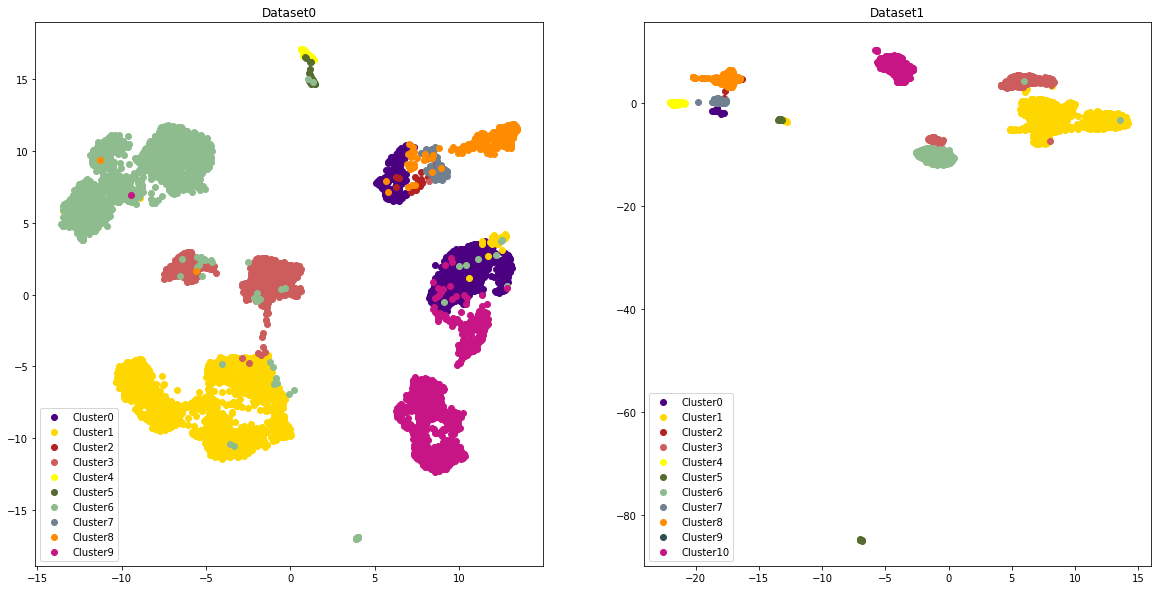

In [44]:
MSingle.Umap_Result()

# Output PopCorn results into a file

In [45]:
FileName = "PopCorn_Human_Mouse_Pan_Reprodcue_Result.txt"
MSingle.OutputResult(FileName)

[ 6  6  6  1  6  6  6  6  6  6  6  3  3  3  3  1  1  1  1  1  1  1  1  1
 10 10 10  0  0  0 10 10 10 10 10 10 10 10 10 11  7  2 11  8  7  8  8  4
  5  8  1  1  1  1  1  1  1  1  1  1  1  1  6  6  6  3  3  3  3 10 10 10
 10  9 10 10 10 10 10 10 10 10 10  8  8  2  8  8  8  8  8  8  7  7 11 11
  4  5  5  1]
8569
1886
